In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns

import pfjax as pf
from pfjax.models.pgnet_model import PGNETModel
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

# parameter values

theta = np.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1])
tau = np.array([1,1,1,1])*1
#x0 = jnp.log(jnp.array([8., 8., 8., 5.]))
theta = np.concatenate([theta, tau])
dt = .1
n_res = 1
n_obs = 2
pgnet_model = PGNETModel(dt, n_res)
pgnet_model2 = PGNETModel(dt, n_res, bootstrap=False)
key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                   [jnp.log(jnp.array([8., 8., 8., 5.]))]])

y_meas, x_state = pf.simulate(pgnet_model, subkey, n_obs, x_init, theta)


In [3]:
import projplot as pjp
def proj_data(fun, x, x_lims, x_names, n_pts=100):
    """
    Wrapper for projxvals and projdata.
    """
    xvals = pjp.projxvals(x, x_lims, n_pts)
    return pjp.projdata(fun, xvals, x_names, is_vectorized=False)

Text(0.5, 1.0, 'Observations and Latent')

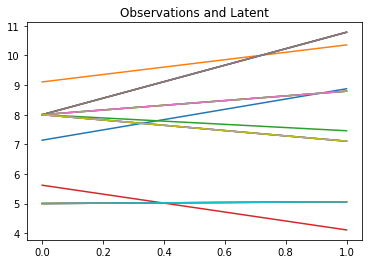

In [4]:
import matplotlib.pyplot as plt
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(y_meas[:, 2])
plt.plot(y_meas[:, 3])
plt.plot(np.exp(x_state[:,0]))
plt.plot(np.exp(x_state[:, 1]))
plt.plot(np.exp(x_state[:, 2]))
plt.plot(np.exp(x_state[:, 3]))
plt.title("Observations and Latent")

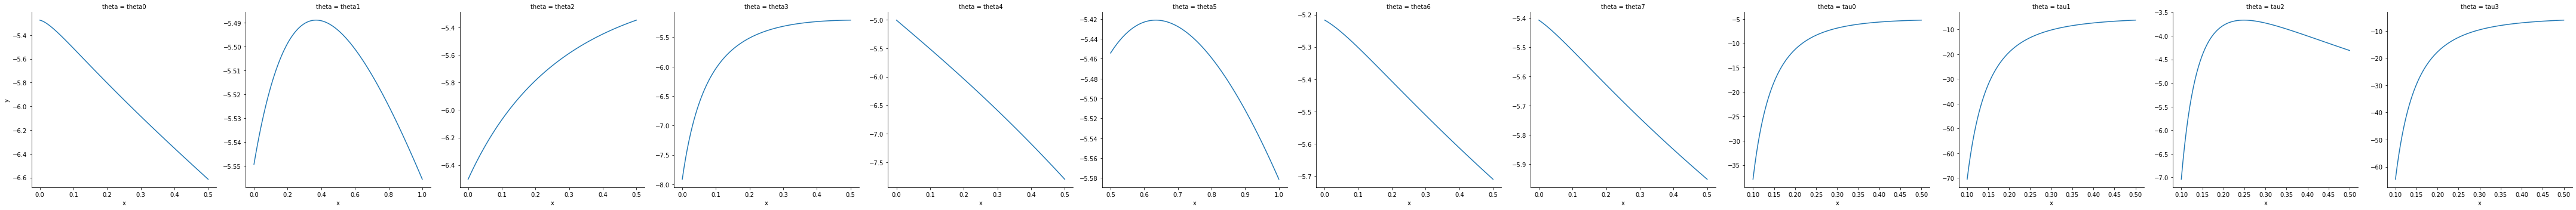

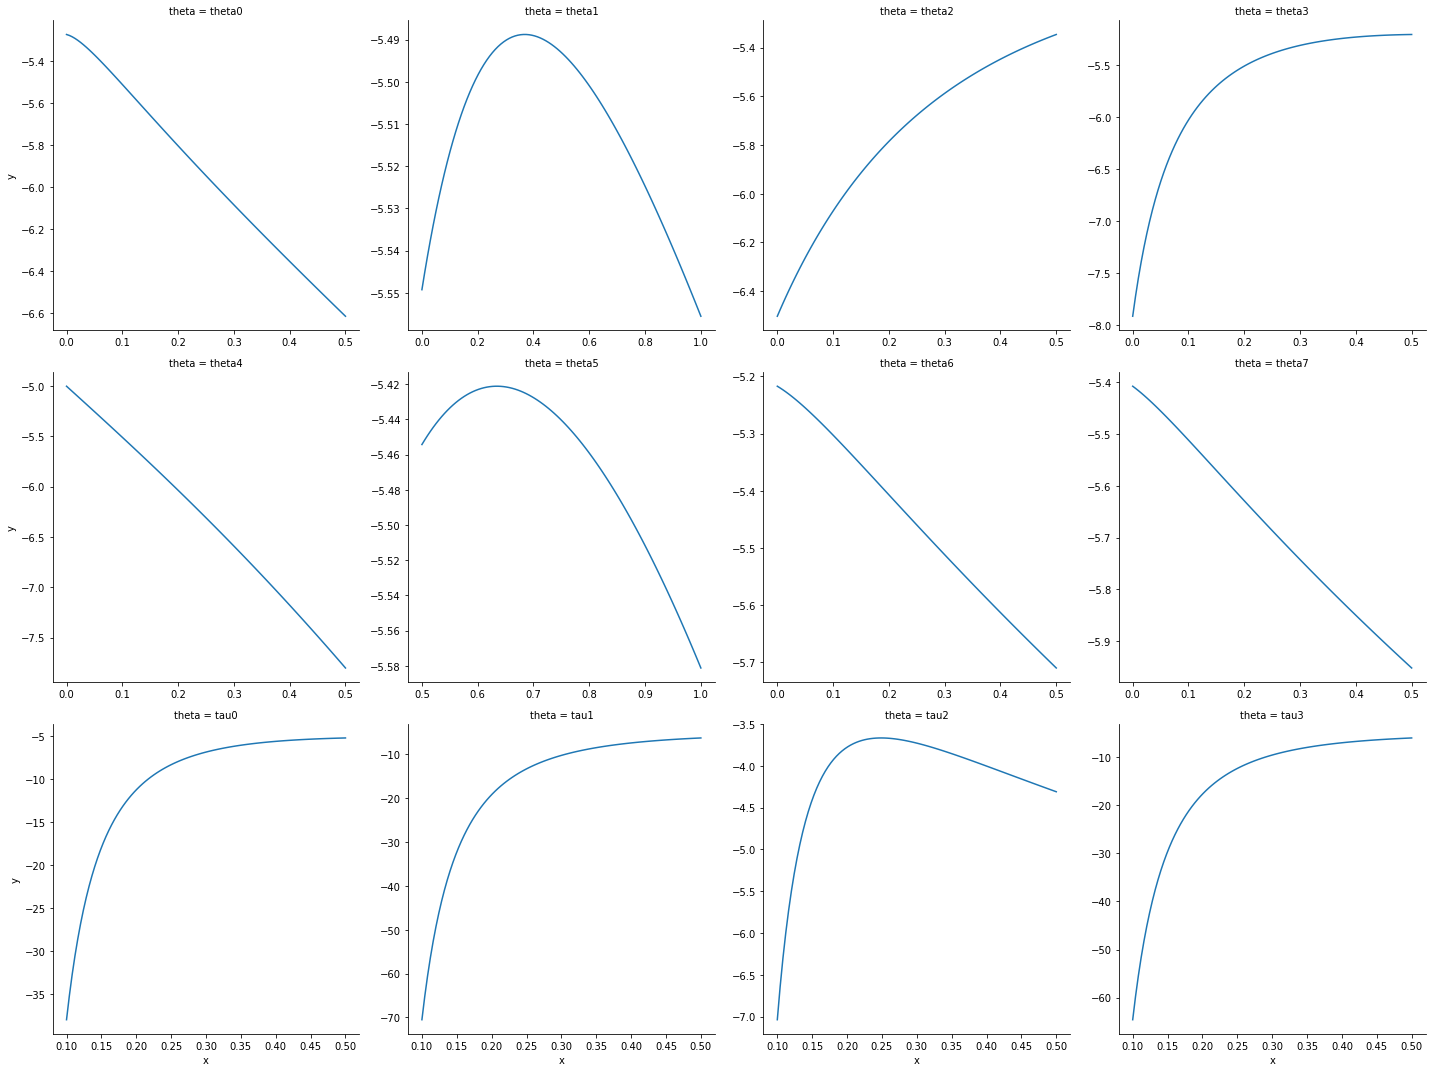

In [5]:
theta_lims = np.array([[0, 0.5], [0,1], [0, 0.5], [0, 0.5], [0, 0.5], [0.5, 1], [0, 0.5], [0, 0.5],
                     [.1, .5], [.1, .5], [.1, .5], [.1, .5]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]
n_pts = 100

# calculate projection plot


@jax.jit
def pgnet_loglik(theta):
    return pf.full_loglik(model=pgnet_model, theta=theta, x_state=x_state, y_meas=y_meas)


plot_df = proj_data(pgnet_loglik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [ ]:
theta_lims = np.array([[0, 0.5], [0,1], [0, 0.5], [0, 0.5], [0, 0.5], [0.5, 1], [0, 0.5], [0, 0.5],
                     [.1, .5], [.1, .5], [.1, .5], [.1, .5]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]
n_pts = 100

# calculate projection plot
n_particles = 1000

@jax.jit
def pgnet_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=pgnet_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(pgnet_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [6]:
n_particles = 1000
particles = jax.jit(pf.particle_filter, static_argnums=(0,4))(theta=theta, model=pgnet_model, y_meas=y_meas,
                               n_particles=n_particles, key=key)

particles2 = jax.jit(pf.particle_filter, static_argnums=(0,4))(theta=theta, model=pgnet_model2, y_meas=y_meas,
                               n_particles=n_particles, key=key)

Check if logweights are constant.

In [4]:
np.isclose(min(particles2['logw'][1]), max(particles2['logw'][1]))

False

## Plots with Log Weights

In [7]:
t_obs= 1
n_samples = 10000

# Bootstrap
x_particles = particles['x_particles'][t_obs, :, 0]
logw = particles['logw'][t_obs]
wgt = jnp.exp(logw - jnp.max(logw))
prob = wgt / jnp.sum(wgt)
ind = random.choice(key, a=n_particles, shape=(n_samples,), p=prob)
x_sample = x_particles[ind]

# Bridge
x_particles2 = particles2['x_particles'][t_obs, :, 0]
logw = particles2['logw'][t_obs]
wgt = jnp.exp(logw - jnp.max(logw))
prob = wgt / jnp.sum(wgt)
ind = random.choice(key, a=n_particles, shape=(n_samples,), p=prob)
x_sample2 = x_particles2[ind]

Text(0.5, 0.98, 'Density plots for observation 1')

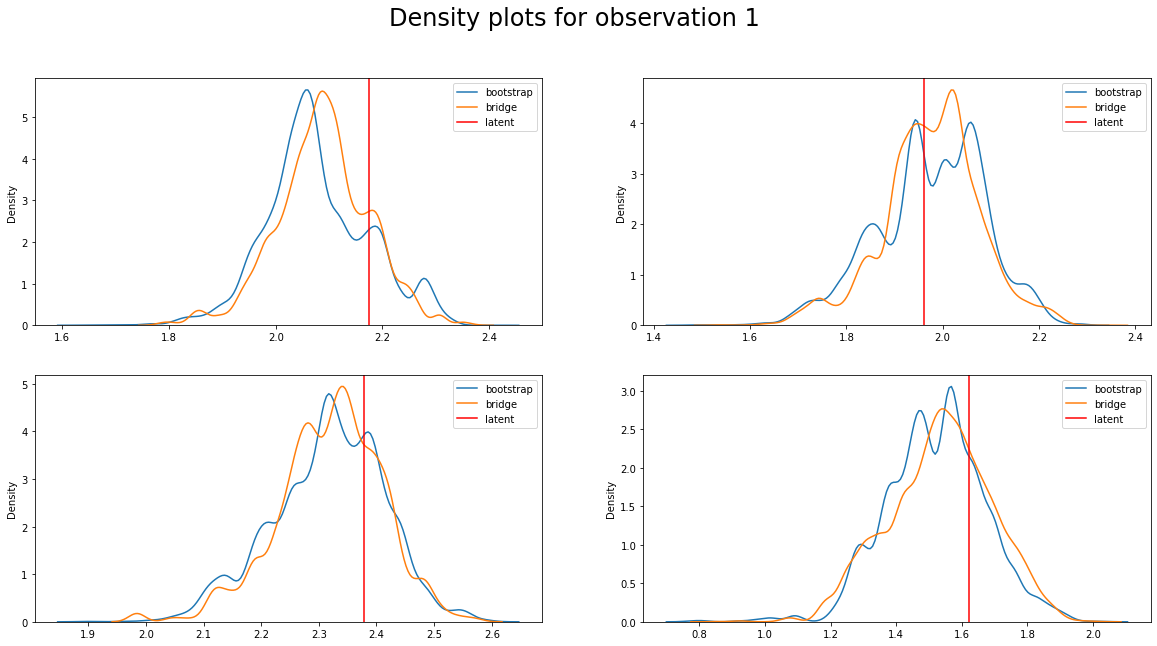

In [8]:
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize=(20,10))
for i in range(4):
    a,b = i % 2, i//2
    sns.kdeplot(data=x_sample[:,i], ax=axs[a,b], label='bootstrap')
    sns.kdeplot(data=x_sample2[:,i], ax=axs[a,b], label='bridge')
    axs[a,b].axvline(x=x_state[1, 0, i], label='latent', color='red')
    axs[a,b].legend()
fig.suptitle('Density plots for observation {}'.format(t_obs), fontsize=24)

## Plots without Log Weights

In [7]:
t_obs= 1
n_samples = 10000

# Bootstrap
x_particles = particles['x_particles'][t_obs, :, 0]
ind = random.choice(key, a=n_particles, shape=(n_samples,))
x_sample = x_particles[ind]

# Bridge
x_particles2 = particles2['x_particles'][t_obs, :, 0]
ind = random.choice(key, a=n_particles, shape=(n_samples,))
x_sample2 = x_particles2[ind]

Text(0.5, 0.98, 'Density plots for observation 1')

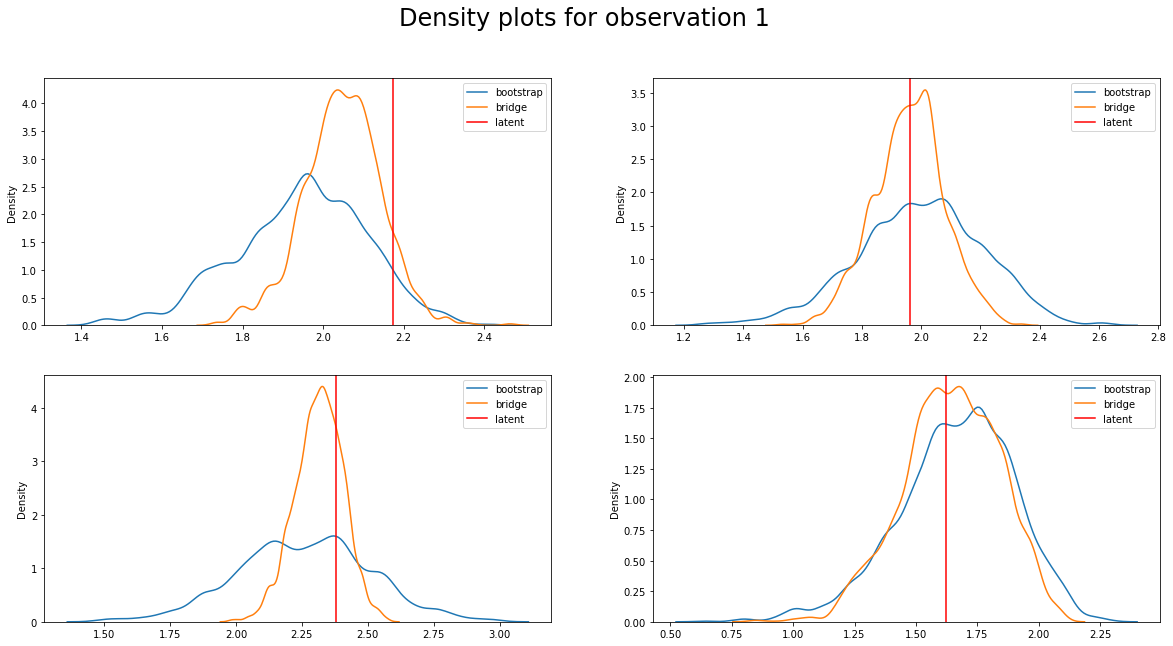

In [8]:
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize=(20,10))
for i in range(4):
    a,b = i % 2, i//2
    sns.kdeplot(data=x_sample[:,i], ax=axs[a,b], label='bootstrap')
    sns.kdeplot(data=x_sample2[:,i], ax=axs[a,b], label='bridge')
    axs[a,b].axvline(x=x_state[t_obs, 0, i], label='latent', color='red')
    #sns.histplot(data=x_sample[:,i], ax=axs[a,b], kde=True, label='bootstrap', alpha=0.2, stat='density')
    #sns.histplot(data=x_sample2[:,i], ax=axs[a,b], kde=True, color='orange', 
    #             label='bridge',alpha=0.2, stat='density')
    axs[a,b].legend()
fig.suptitle('Density plots for observation {}'.format(t_obs), fontsize=24)

## Experiment with Increase Resolution and Smaller Noise

In [9]:
key = random.PRNGKey(1)

# parameter values
theta = np.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1])
tau = np.array([1,1,1,1])*2
theta = np.concatenate([theta, tau])
n_res = 10
n_obs = 10
pgnet_model = PGNETModel(dt, n_res)
key, subkey = random.split(key)
x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                   [jnp.log(jnp.array([8., 8., 8., 5.]))]])
y_meas, x_state = pf.simulate(pgnet_model, subkey, n_obs, x_init, theta)


In [10]:
n_particles = 1000
particles = jax.jit(pf.particle_filter, static_argnums=(0,4))(theta=theta, model=pgnet_model, y_meas=y_meas,
                               n_particles=n_particles, key=key)

particles2 = jax.jit(pf.particle_filter, static_argnums=(0,4))(theta=theta, model=pgnet_model2, y_meas=y_meas,
                               n_particles=n_particles, key=key)

In [13]:
np.isclose(min(particles2['logw'][-1]), max(particles2['logw'][-1]))

False

In [11]:
t_obs= 10
n_samples = 1000

# Bootstrap
x_particles = particles['x_particles'][t_obs, :, -1]
logw = particles['logw'][t_obs]
wgt = jnp.exp(logw - jnp.max(logw))
prob = wgt / jnp.sum(wgt)
ind = random.choice(key, a=n_particles, shape=(n_samples,), p=prob)
x_sample = x_particles[ind]

# Bridge
x_particles2 = particles2['x_particles'][t_obs, :, -1]
logw = particles2['logw'][t_obs]
wgt = jnp.exp(logw - jnp.max(logw))
prob = wgt / jnp.sum(wgt)
ind = random.choice(key, a=n_particles, shape=(n_samples,), p=prob)
x_sample2 = x_particles2[ind]

Text(0.5, 0.98, 'Density plots for observation 10')

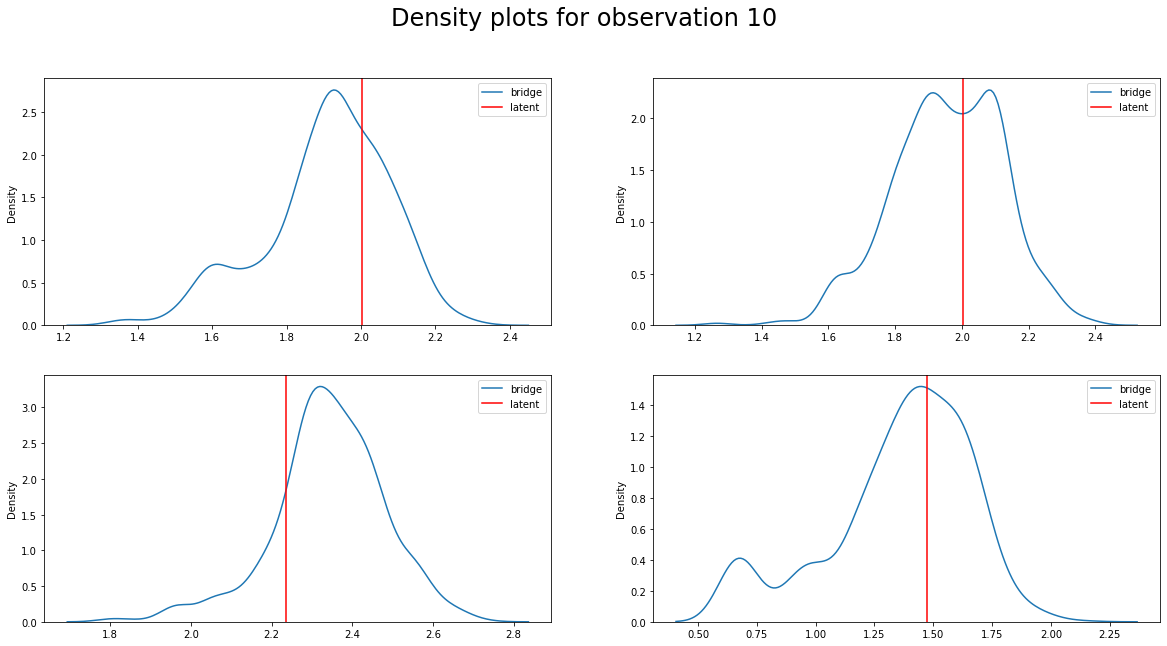

In [12]:
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize=(20,10))
for i in range(4):
    a,b = i % 2, i//2
    #sns.kdeplot(data=x_sample[:,i], ax=axs[a,b], label='bootstrap')
    sns.kdeplot(data=x_sample2[:,i], ax=axs[a,b], label='bridge')
    axs[a,b].axvline(x=x_state[t_obs, -1, i], label='latent', color='red')
    axs[a,b].legend()
fig.suptitle('Density plots for observation {}'.format(t_obs), fontsize=24)